# Description

A Colab notebook for generating images using OpenAI's CLIP model.

Heavily influenced by Alexander Mordvintsev's Deep Dream, this work uses CLIP to match an image learned by a SIREN network with a given textual description.


As a good launching point for future directions and to find more related work, see https://distill.pub/2017/feature-visualization/


If you have questions, please see my twitter at https://twitter.com/advadnoun

This is all free! But if you're feeling generous, you can donate to my venmo @rynnn while your "a beautiful Waluigi" loads ;)


# Top



Import the usual libraries

In [1]:
import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



Check which GPU Colab has assigned to you

In [2]:
!nvidia-smi -L


GPU 0: Tesla T4 (UUID: GPU-5bfb5ce1-5e45-26c7-2f4a-0dd5d6f603d6)


# Restart after running this cell!

You must run this cell and then restart and rerun everything for the PyTorch version to be correct. Otherwise the model will run but not produce any meaningful output.

In [3]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

! pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.1 MB/s eta 0:04:45tcmalloc: large alloc 1147494400 bytes == 0x3922c000 @  0x7effcca8a615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0x49ced5
     |█████████████████████████████▏  | 1055.7 MB 1.1 MB/s eta 0:01:29tcmalloc: large alloc 1434370048 bytes == 0x7d882000 @  0x7effcca8a615 0x5d631c 0x51e4f1 0x51e67b 0x4f7585 0x49ca7c 0x4fdff5 0x49caa1 0x4fdff5 0x49ced5 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x4f60a9 0x55f926 0x5d7c18 0x5d9412 0x586636 0x5d813c 0x55f3fd 0x55e571 0x5d7cf1 0x49ced5 0x55e571 0x5d7cf1 0x49ec69 0x5d7c18 0x49ca7c 0x4fdff5 0

# CLIP

Setup CLIP and set it to be the "perceptor" used to determine the loss for the SIREN network.

Thanks to the authors below & OpenAI for sharing! https://github.com/openai/CLIP

Alec Radford \* Jong Wook Kim \* Chris Hallacy Aditya Ramesh Gabriel Goh Sandhini Agarwal
Girish Sastry Amanda Askell Pamela Mishkin Jack Clark Gretchen Krueger
Ilya Sutskever



In [4]:


%cd /content/

!git clone https://github.com/openai/CLIP.git


%cd /content/CLIP/

!pip install ftfy

import clip


import numpy as np
# Load the model
perceptor, preprocess = clip.load('ViT-B/32')


/content
Cloning into 'CLIP'...
remote: Enumerating objects: 236, done.
remote: Total 236 (delta 0), reused 0 (delta 0), pack-reused 236
Receiving objects: 100% (236/236), 8.92 MiB | 26.25 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/CLIP
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|████████████████████████████████████████| 338M/338M [00:02<00:00, 150MiB/s]


# Params

Determine the output dimensions of the image and the number of channels.

Set the text to be matched

In [5]:
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape

tx = clip.tokenize("a beautiful Waluigi")

# Define

Define some helper functions

In [6]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)


# SIREN

Thanks to the authors of SIREN! https://github.com/vsitzmann/siren

@inproceedings{sitzmann2019siren,
    author = {Sitzmann, Vincent
              and Martel, Julien N.P.
              and Bergman, Alexander W.
              and Lindell, David B.
              and Wetzstein, Gordon},
    title = {Implicit Neural Representations
              with Periodic Activation Functions},
    booktitle = {arXiv},
    year={2020}
}


The number of layers is 16 right now, but if the machine OOMs (runs out of RAM), it can naturally be tweaked. I've found that 16 layers for the SIREN works best, but I'm not always blessed with a V100 GPU.

In [7]:

import torch.nn as nn

class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=True, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords.cuda())
        return output.view(1, sideX, sideY, 3).permute(0, 3, 1, 2)#.sigmoid_()

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


model = Siren(2, 256, 16, 3).cuda()
LLL = []
eps = 0

optimizer = torch.optim.Adam(model.parameters(), .00001)

In [8]:
make sure you're on this page when train first starts running, and it dings
otherwise the thing'll never start

SyntaxError: ignored

# Train

Train and output samples every 150 iterations

We create batches of images at different resolutions in different parts of the SIREN image and resize them with bilinear upsampling. This seems to work very, very well as regularization for visualizing networks with larger images than their usual input resolution.

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor(-22.6250, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


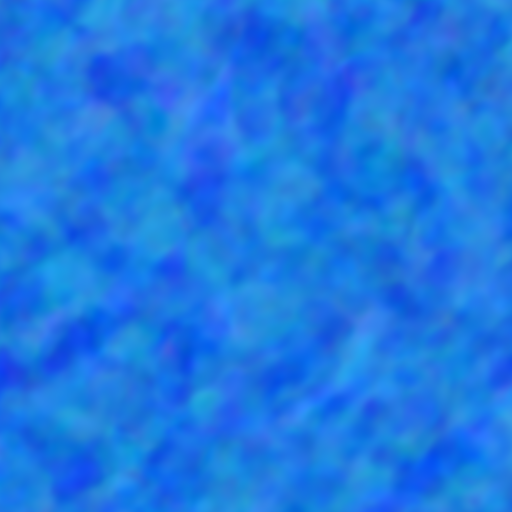



tensor(-49.8750, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


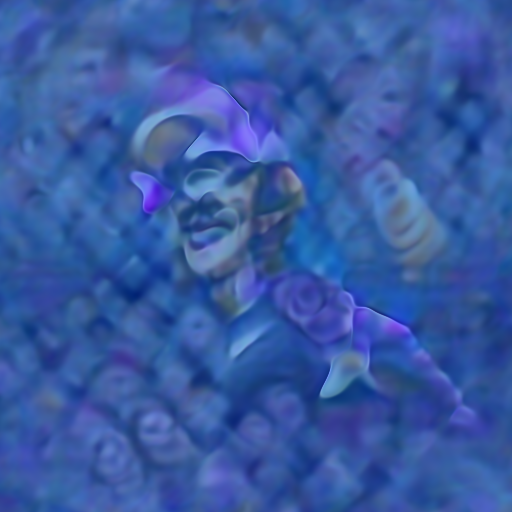



tensor(-54.8750, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


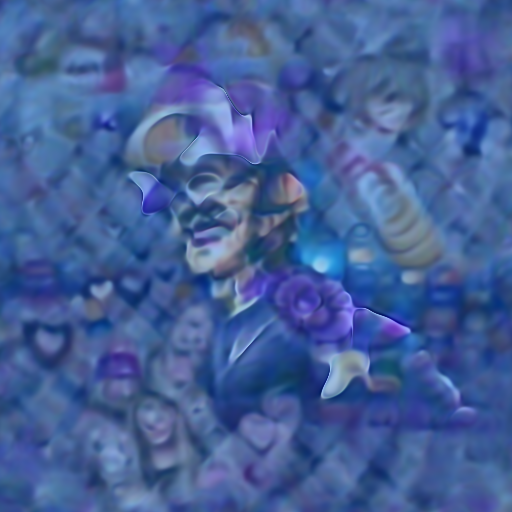



tensor(-55.6562, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


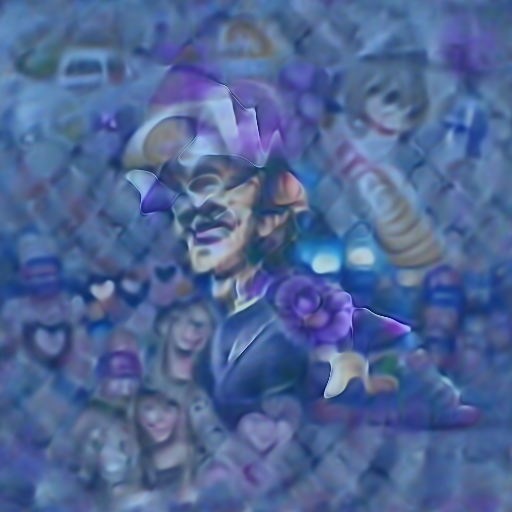



tensor(-57.5312, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


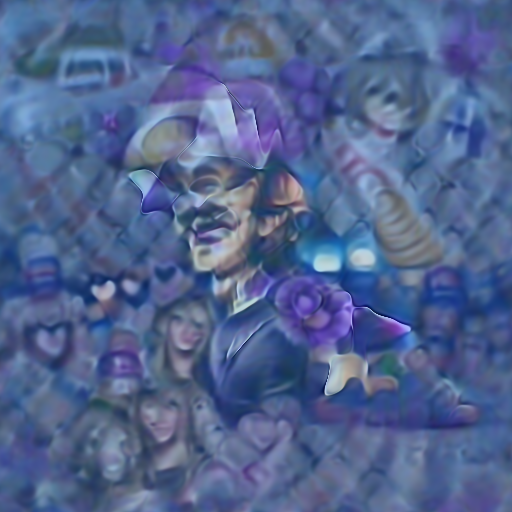



tensor(-58.3125, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


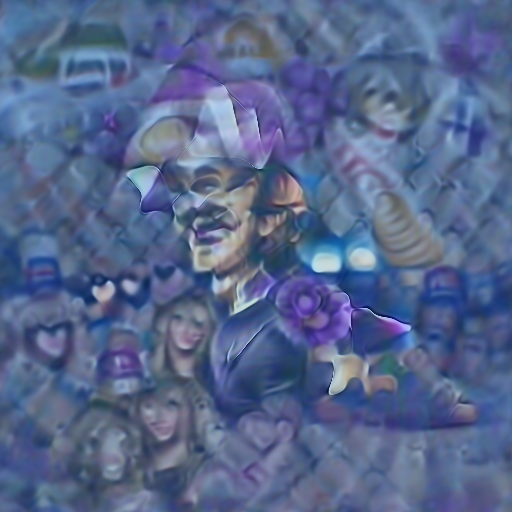



tensor(-59.5625, device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)


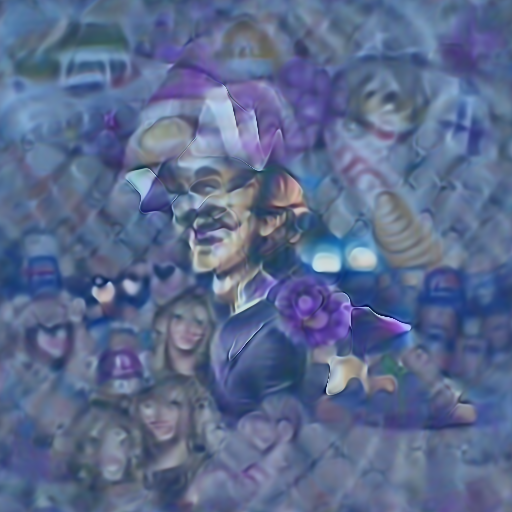

KeyboardInterrupt: ignored

In [9]:



def checkin(loss):
  print(loss)
  with torch.no_grad():
    al = nom(model(get_mgrid(sideX)).cpu()).numpy()
  for allls in al:
    displ(allls)
    display.display(display.Image(str(3)+'.png'))
    print('\n')
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = model(get_mgrid(sideX))

  cutn = 64
  p_s = []
  for ch in range(cutn):
    size = torch.randint(int(.5*sideX), int(.98*sideX), ())
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(nom(apper))
  into = torch.cat(p_s, 0)


  
  iii = perceptor.encode_image(into)
  t = perceptor.encode_text(tx.cuda())
  return -100*torch.cosine_similarity(t, iii, dim=-1).mean()

def train(epoch, i):
  loss = ascend_txt()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  

  
  
  if itt % 150 == 0:
    checkin(loss)

nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))


itt = 0
for epochs in range(10000):
  for i in range(1000):
    train(eps, i)
    itt+=1
  eps+=1


# Bot